In [1]:
%load_ext jupyter_black

## Bayessian Optimization

---
Few popular acquisition functions:

1. **Expected Improvement (EI)**
$$
\text{EI}(x) = (\mu(x) - f^*)\Phi(z^*) + \sigma(x)\phi(z^*)
$$

2. **Upper Confidence Bound (UCB)**
$$
\text{UCB}(x) = \mu(x) + \beta \sigma(x)
$$

3. **Maximum Probability of Improvement (MPI)**
$$
\text{MPI}(x) = \Phi\left(\frac{\mu(x) - f^*}{\sigma(x)}\right)
$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern


plt.rcParams["figure.dpi"] = 600
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["figure.figsize"] = (12, 6)
%matplotlib inline

In [3]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2


def f(X, noise=noise):
    return -np.sin(3 * X) - X**2 + 0.7 * X + noise * np.random.randn(*X.shape)


X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

C:\Users\anaki\AppData\Local\Temp\ipykernel_13976\2711309137.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)


C:\Users\anaki\AppData\Local\Temp\ipykernel_13976\1741420537.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)


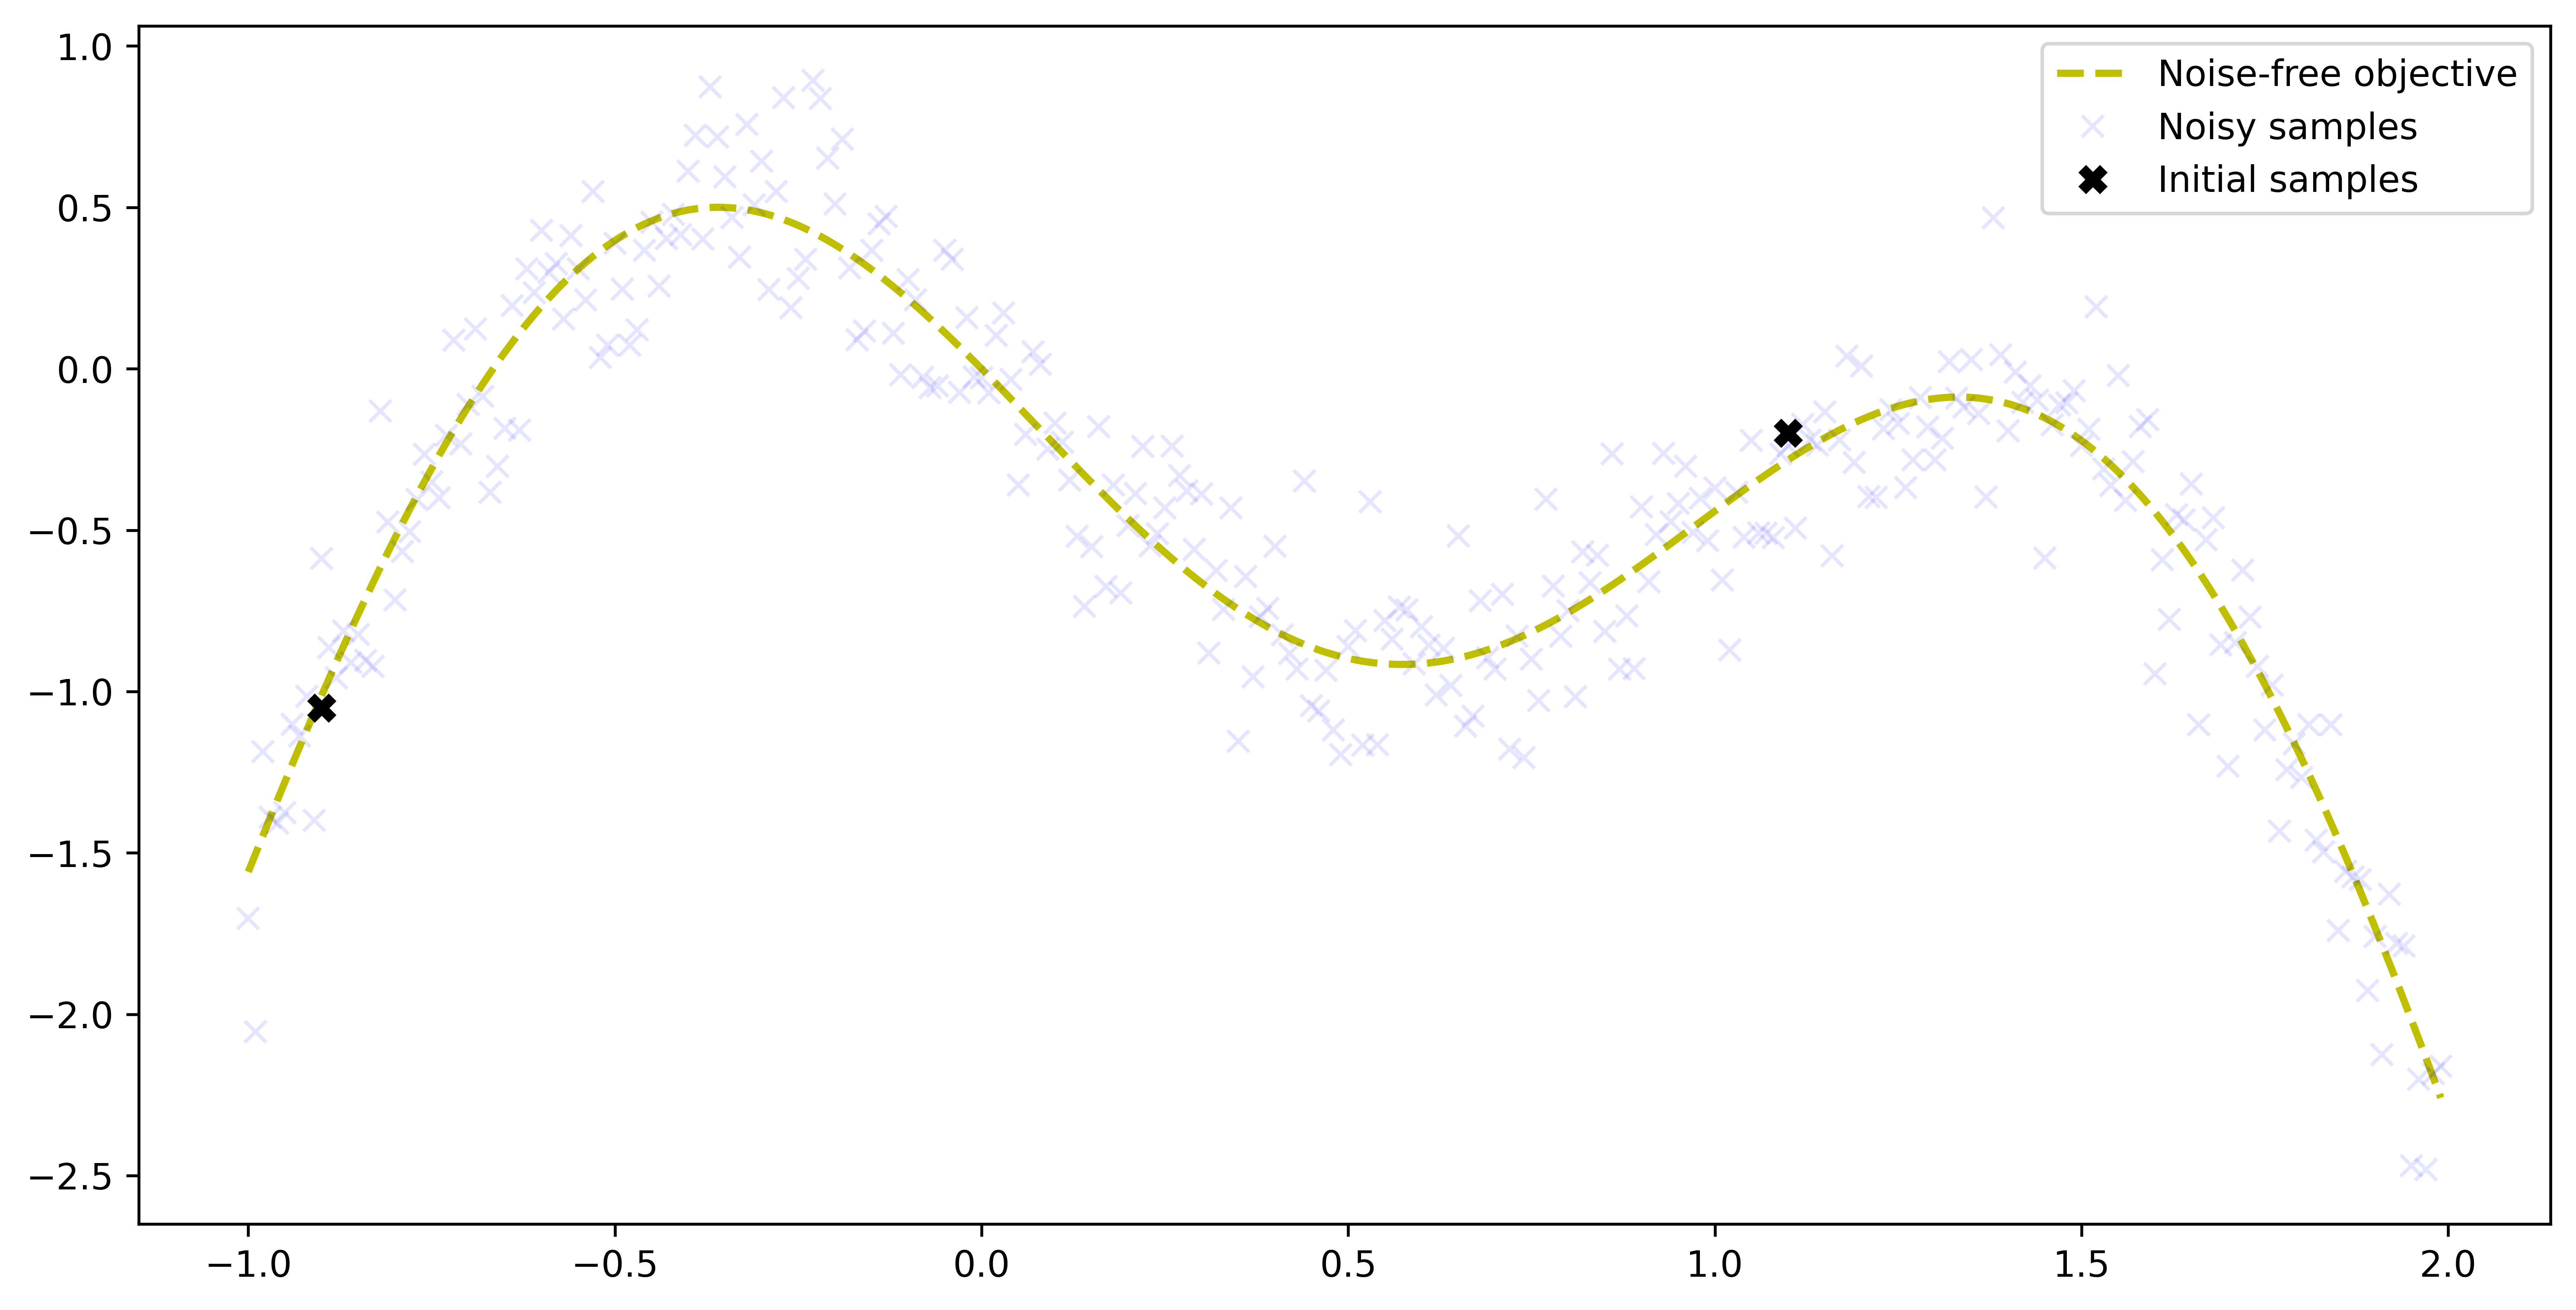

In [4]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X
Y = f(X, 0)

# Plot optimization objective with noise level
plt.plot(X, Y, "y--", lw=2, label="Noise-free objective")
plt.plot(X, f(X), "bx", lw=1, alpha=0.1, label="Noisy samples")
plt.plot(X_init, Y_init, "kx", mew=3, label="Initial samples")
plt.legend();

In [5]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2


def f(X, noise=noise):
    return -np.sin(3 * X) - X**2 + 0.7 * X + noise * np.random.randn(*X.shape)


X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

In [6]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(
        X.ravel(), mu.ravel() + 1.96 * std, mu.ravel() - 1.96 * std, alpha=0.1
    )
    plt.plot(X, Y, "y--", lw=1, label="Noise-free objective")
    plt.plot(X, mu, "b-", lw=1, label="Surrogate function")
    plt.plot(X_sample, Y_sample, "kx", mew=3, label="Noisy samples")
    if X_next:
        plt.axvline(x=X_next, ls="--", c="k", lw=1)
    if show_legend:
        plt.legend()


def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, "r-", lw=1, label="Acquisition function")
    plt.axvline(x=X_next, ls="--", c="k", lw=1, label="Next sampling location")
    if show_legend:
        plt.legend()


def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x) + 1)

    x_neighbor_dist = [np.abs(a - b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)

    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, "bo-")
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.title("Distance between consecutive x's")

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, "ro-")
    plt.xlabel("Iteration")
    plt.ylabel("Best Y")
    plt.title("Value of best selected sample")

In [25]:
def bayessian_optimization(acquisiition_fn, n_iter=3):
    m52 = Matern(nu=2.5, length_scale=1.0) * ConstantKernel(1.0)
    gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

    X_sample = X_init
    y_sample = Y_init

    plt.figure(figsize=(12, 3 * n_iter))
    bounds = np.array([[-1.0, 2.0]])

    for i in range(n_iter):

        gpr.fit(X_sample, y_sample)

        X_new = propose_location(acquisiition_fn, gpr, bounds, n_restarts=25)
        y_new = f(X_new, noise)

        # Plot samples, surrogate function, noise-free objective and next sampling location
        plt.subplot(n_iter, 2, 2 * i + 1)
        plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i == 0)
        plt.title(f"Iteration {i+1}")

        plt.subplot(n_iter, 2, 2 * i + 2)
        plot_acquisition(
            X,
            probability_of_improvement(X, X_sample, Y_sample, gpr),
            X_next,
            show_legend=i == 0,
        )

        # Add sample to previous samples
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

In [26]:
def upper_confidence_bound(X, gpr, beta=1):
    mu, s = gpr.predict(X, return_std=True)
    return mu + beta * s

In [36]:
def propose_location(acquisition, gpr, bounds, n_restarts=25, **kwargs):
    res = minimize(
        np.array([0.0]),
        lambda x: -acquisition(x, gpr, **kwargs),
        method="L-BFGS-B",
        bounds=bounds,
    )
    return res.x

In [37]:
bayessian_optimization(upper_confidence_bound, 3)

TypeError: '>=' not supported between instances of 'function' and 'float'

<Figure size 7200x5400 with 0 Axes>

In [33]:
def probability_of_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    return ...

In [ ]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    return ...

## Bayesian optimization libraries

There are numerous Bayesian optimization libraries out there and giving a comprehensive overview is not the goal of this article. Instead, I'll pick two that I used in the past and show the minimum setup needed to get the previous example running.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) is a library for sequential model-based optimization that is based on [scikit-learn](http://scikit-learn.org/). It also supports Bayesian optimization using Gaussian processes. The API is designed around minimization, hence, we have to provide negative objective function values.  The results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function.

In [ ]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(
    lambda x: -f(np.array(x))[0],
    bounds.tolist(),
    base_estimator=gpr,
    acq_func="EI",  # expected improvement
    xi=0.01,  # exploitation-exploration trade-off
    n_calls=10,  # number of iterations
    n_random_starts=0,  # initial samples are provided
    x0=X_init.tolist(),  # initial samples
    y0=-Y_init.ravel(),
)

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

In [ ]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

## Application: tuning model hyperparameters

In [ ]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization
baseline = cross_val_score(xgb, X, Y, scoring="neg_mean_squared_error").mean()

### Hyperparameter tuning with random search

For hyperparameter tuning with random search, we use `RandomSearchCV` of scikit-learn and compute a cross-validation score for each randomly selected point in hyperparameter space. Results will be discussed below.

In [ ]:
# Hyperparameters to tune and their ranges
param_dist = {
    "learning_rate": uniform(0, 1),
    "gamma": uniform(0, 5),
    "max_depth": range(1, 50),
    "n_estimators": range(1, 300),
    "min_child_weight": range(1, 10),
}

rs = RandomizedSearchCV(
    xgb, param_distributions=param_dist, scoring="neg_mean_squared_error", n_iter=25
)

# Run random search for 25 iterations
rs.fit(X, Y);

### Hyperparameter tuning with Bayesian optimization


In [ ]:
...

---

This noptebook rely heavily on Martin Krasser's [course](https://github.com/krasserm) on Bayessian Machine Learning 